# General

In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import colorsys
import copy
import pickle

import lib_operations as operations
import lib_data_load as data_load
from lib_models import model_3sr,model_4pr
import scipy.optimize 

def scale_lightness(input_color, scale_l):
    rgb = matplotlib.colors.ColorConverter.to_rgb(input_color)
    # convert rgb to hls
    h, l, s = colorsys.rgb_to_hls(*rgb)
    # manipulate h, l, s values and return as rgb
    return colorsys.hls_to_rgb(h, min(1, l * scale_l), s = s)

def rolling_avg(x,window_width=20):
    cumsum_vec = np.cumsum(np.insert(x, 0, 0)) 
    temp = (cumsum_vec[window_width:] - cumsum_vec[:-window_width]) / window_width
    for i in range(1,len(temp)):
        if temp[i]>temp[i-1]:
            temp[i]=temp[i-1]
    return temp

make_plot = lambda n,m,s=[1,1]: plt.subplots(n,m,figsize=(m*4*s[0],n*2.8*s[1]),squeeze=False,layout='tight')

_plot_vis           = {}
_plot_vis['color']  = ['black','red','blue','green','orange','purple','brown','pink']
_plot_vis['style']  = ['solid','dashed','dotted','dashdot']
_plot_vis['marker'] = ['o','v','s','D','X']

np.set_printoptions(suppress=True)
plt.rcParams['text.usetex'] = True
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 11})
plt.rcParams['text.latex.preamble'] = r"\usepackage{bm} \usepackage{amsmath}"

_conditions='PD'

In [2]:
_root               = 'result/'+_conditions+'/1_s/T-250/'
_rho_sel            = ['0.01','0.0001','0.0001']

_test_name_no_pen   = str('MMM-')+str('0.0_0.0_0.0') 
_test_name_q2_q3    = str('MMM-')+str('0.0')+str('_')+str(_rho_sel[1])+str('_') +str(_rho_sel[2])                            
_test_name_q1_q2_q3 = str('MMM-')+str(_rho_sel[0])+str('_')+str(_rho_sel[1])+str('_') +str(_rho_sel[2])      
_test_name_q1_q2    = str('MMM-')+str(_rho_sel[0])+str('_')+str(_rho_sel[1])+str('_') +str('0.0')        
_model_set          = [model_3sr,model_4pr]

# full result
_results = {}
temp = operations.load_results(root=_root,test_name=_test_name_q1_q2, model_set=_model_set, T_sim_set=[50,125,250,500],conditions=_conditions)
_results['3SR'] = copy.copy(temp['3SR'])

temp = operations.load_results(root=_root,test_name=_test_name_q1_q2_q3, model_set=_model_set, T_sim_set=[50,125,250,500],conditions=_conditions)
_results['4PR'] = copy.copy(temp['4PR'])
operations.tabulate(_results,title='result', vars=['a','m_eq','time_scale','err_l2_50','err_l2_125','err_l2_250','err_l2_500','diff_o_l'])

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|                                                                                                  result                                                                                                  |
+-------+----------------+------------------------+---------------------------------+-------------------------------+------------------------+-----------+------------+------------+------------+----------+
| model | benchmark_name |          rho           |                a                |              m_eq             |       time_scale       | err_l2_50 | err_l2_125 | err_l2_250 | err_l2_500 | diff_o_l |
+-------+----------------+------------------------+---------------------------------+-------------------------------+------------------------+-----------+------------+------------+

# Reducing Search Space

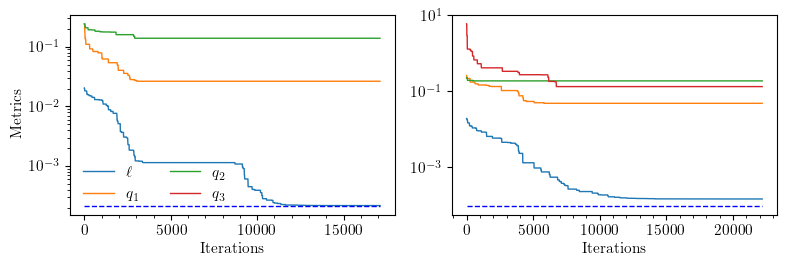

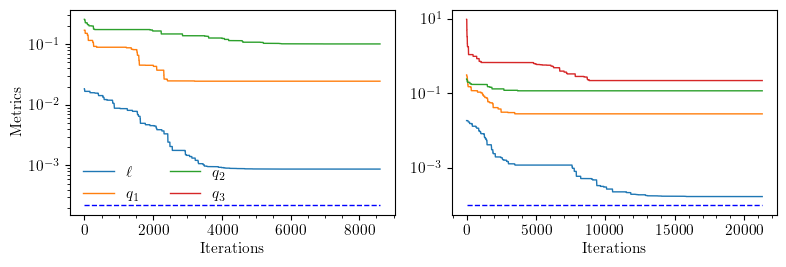

In [3]:
def plot_convergence(test_name_base,test_name_sel,root=_root):

    calib_data    = operations.load_results(root=root, test_name=test_name_sel,T_sim_set=[50,125,250,500],conditions=_conditions)
    opt_data_base = operations.load_opt_data(root=root,test_name=test_name_base)
    opt_data      = operations.load_opt_data(root=root,test_name=test_name_sel)

    labels = ['loss','$q_1$','$q_2$','$q_3$']
    fig, axs = make_plot(1,2)
    for i, model_name in enumerate(['3SR','4PR']):

        data = rolling_avg(opt_data[model_name]['_metric_loss'])  
        axs[0,i].semilogy(data,linewidth=1,label=r'$\ell$') 

        data_base = rolling_avg(opt_data_base[model_name]['_metric_loss'])  
        axs[0,i].hlines(y=data_base[-1],xmin=0,xmax=len(data),linewidth=1,label=r'_Baseline $\ell$',color='b',linestyle='--') 

        data = rolling_avg(opt_data[model_name]['_metric_pen_1'])
        axs[0,i].semilogy(data,linewidth=1,label=r'$q_1$') 

        data = rolling_avg(opt_data[model_name]['_metric_pen_2'])
        axs[0,i].semilogy(data,linewidth=1,label=r'$q_2$') 

        data = rolling_avg(opt_data[model_name]['_metric_pen_3'])  
        axs[0,i].semilogy(data,linewidth=1,label=r'$q_3$') 

    axs[0,0].legend(loc='lower left',frameon=False,ncol=2)
    axs[0,1].minorticks_on()
    axs[0,0].minorticks_on()

    for model_inx,model_name in enumerate(calib_data.keys()):   
        axs[-1,model_inx].set_xlabel(r'Iterations')       

    axs[0,0].set_ylabel(r'Metrics')   

plot_convergence(test_name_base=_test_name_no_pen,test_name_sel=_test_name_q2_q3)
plot_convergence(test_name_base=_test_name_no_pen,test_name_sel=_test_name_q1_q2_q3)

# Selecting Good Tunning Prameter -  Error & Dynamic Time Scales

/var/folders/d2/9qb3m2t14ts4c5lnwscq22b80000gn/T/ipykernel_62923/236125456.py:95: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  axs[1,model_inx].set_ylim(bottom=0,top=1e5)


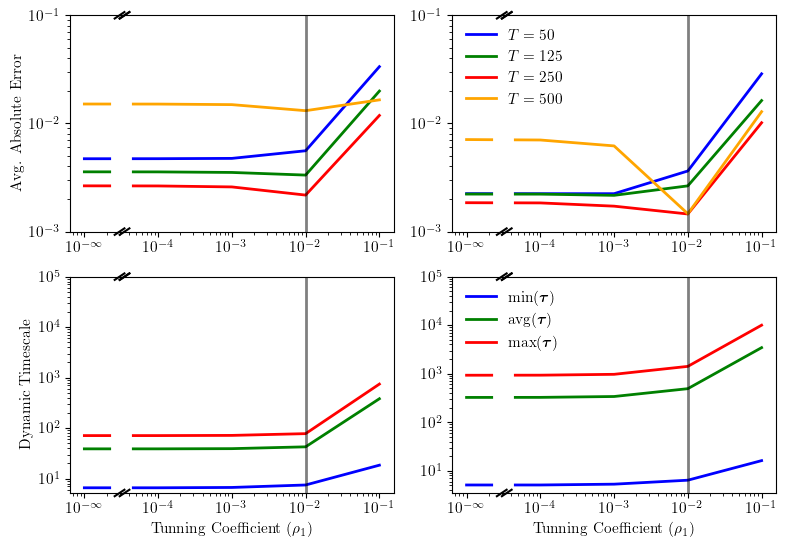

In [4]:
def zero_break_Line(ax,x,is_log=True):

    xmin,xmax = ax.get_xlim()

    if is_log:
        z = (np.log10(x) - np.log10(xmin)) / (np.log10(xmax)-np.log10(xmin))
    else:
        z = (x - xmin) / (xmax-xmin)

    d = .015 # how big to make the diagonal lines in axes coordinates
    # arguments to pass plot, just so we don't keep repeating them

    ax.axvline(x*1.05,linewidth=15, color='w',alpha=1)
    #ax.axvline(x*1.05,linewidth=12, color='k',alpha=.1)

    kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
    ax.plot((z-d,z+d),(-d,+d), **kwargs)
    ax.plot((z-d,z+d),(1-d,1+d), **kwargs)
    ax.plot((z*1.1-d,z*1.1+d), (-d,+d), **kwargs)
    ax.plot((z*1.1-d,z*1.1+d),(1-d,1+d), **kwargs)
    ax.plot((z*1.1-d,z*1.1+d),(1-d,1+d), **kwargs)

    temp = [item.get_text() for item in ax.get_xticklabels()]
    temp[0] =r'$\mathdefault{10^{-\infty}}$'

    ax.set_xticklabels(temp)

def plot_rho(results,model_name_set=['3SR','4PR'], root=_root):

    fig, axs = make_plot(2,2)

    for model_inx, model_name in enumerate(model_name_set):
            
        rho_1 = results[model_name]['rho'][0]

        T_sim_set  = [50,125,250,500]
        rho_set    = [0.0, 0.0001, 0.001, 0.01, 0.1]
        
        rho_sel    = results[model_name]['rho']

        err_0 = np.zeros(shape=(len(rho_set)))
        err_1 = np.zeros(shape=(len(rho_set)))
        err_2 = np.zeros(shape=(len(rho_set)))
        err_3 = np.zeros(shape=(len(rho_set)))

        eig_0 = np.zeros(shape=(len(rho_set)))
        eig_1 = np.zeros(shape=(len(rho_set)))
        eig_2 = np.zeros(shape=(len(rho_set)))

        calib_data_base = operations.load_results(root=root,test_name='MMM-0.0_0.0_0.0',T_sim_set=T_sim_set,conditions=_conditions)

        for i in range(0,len(rho_set)):           
            test_name ='MMM'+'-'+'_'.join([str(rho_set[i]),str(rho_sel[1]),str(rho_sel[2])])
            calib_data = operations.load_results(root=root,test_name=test_name,T_sim_set=T_sim_set,conditions=_conditions)
            
            # Compute the first metric
            err_0[i] = calib_data[model_name]['err_l1_'+str(T_sim_set[0])] #/ calib_data_base[model_name]['err_l2_'+str(T_sim_set[0])] 
            err_1[i] = calib_data[model_name]['err_l1_'+str(T_sim_set[1])] #/ calib_data_base[model_name]['err_l2_'+str(T_sim_set[1])] 
            err_2[i] = calib_data[model_name]['err_l1_'+str(T_sim_set[2])] #/ calib_data_base[model_name]['err_l2_'+str(T_sim_set[2])] 
            err_3[i] = calib_data[model_name]['err_l1_'+str(T_sim_set[3])] #/ calib_data_base[model_name]['err_l2_'+str(T_sim_set[3])] 

            eig_0[i] = np.min(calib_data[model_name]['time_scale']  )
            eig_1[i] = np.mean(calib_data[model_name]['time_scale']  )
            eig_2[i] = np.max(calib_data[model_name]['time_scale']  )

        rho_set[0]=1e-5

        label = r'$T='+str(T_sim_set[0])+'$'
        axs[0,model_inx].loglog(rho_set[0:],err_0[0:] ,linewidth=2,alpha=1,label=label,color='blue')
        label = r'$T='+str(T_sim_set[1])+'$'
        axs[0,model_inx].loglog(rho_set[0:],err_1[0:] ,linewidth=2,alpha=1,label=label,color='green')
        label = r'$T='+str(T_sim_set[2])+'$'
        axs[0,model_inx].loglog(rho_set[0:],err_2[0:] ,linewidth=2,alpha=1,label=label,color='red')
        label = r'$T='+str(T_sim_set[3])+'$'
        axs[0,model_inx].loglog(rho_set[0:],err_3[0:] ,linewidth=2,alpha=1,label=label,color='orange')

        axs[0,model_inx].minorticks_on()
        #axs[0,model_inx].legend(loc='upper left',frameon=False,ncol=2)
        #axs[0,model_inx].set_xlabel(r'Tunning Coefficient ($\mathbf{\rho}_1$)')
        axs[0,model_inx].set_ylim(bottom=1e-3,top=1e-1)
        axs[0,model_inx].minorticks_on()
        axs[0,model_inx].set_xticks(rho_set)
        axs[0,model_inx].axvline(x=max(1e-5,rho_1),ymax=1,color='black',alpha=0.5,linewidth=2)
        zero_break_Line(axs[0,model_inx],3e-5)

        label = r'$\textrm{min}(\boldsymbol{\tau})$'
        axs[1,model_inx].loglog(rho_set[0:],eig_0[0:] ,linewidth=2,alpha=1,label=label,color='blue')
        label = r'$\textrm{avg}(\boldsymbol{\tau})$'
        axs[1,model_inx].loglog(rho_set[0:],eig_1[0:] ,linewidth=2,alpha=1,label=label,color='green')
        label = r'$\textrm{max}(\boldsymbol{\tau})$'
        axs[1,model_inx].loglog(rho_set[0:],eig_2[0:] ,linewidth=2,alpha=1,label=label,color='red')
        
        axs[1,model_inx].minorticks_on()
        axs[1,model_inx].set_xticks(rho_set[0:])
        axs[1,model_inx].set_ylim(bottom=0,top=1e5)
        axs[1,model_inx].axvline(x=max(1e-5,rho_1),ymax=1,color='black',alpha=0.5,linewidth=2)
        zero_break_Line(axs[1,model_inx],3e-5)
        
    axs[0,1].legend(loc='upper left',frameon=False,ncol=1)
    axs[1,1].legend(loc='upper left',frameon=False,ncol=1)

    axs[0,0].set_ylabel(r'Avg. Absolute Error')  
    axs[1,0].set_ylabel(r'Dynamic Timescale') 
    axs[-1,0].set_xlabel(r'Tunning Coefficient $({\rho}_1)$')
    axs[-1,1].set_xlabel(r'Tunning Coefficient $({\rho}_1)$')
    fig.savefig('fig/'+_conditions+'/analysis_rho_1_sel.png',dpi=300)

plot_rho(results=_results)

#Weighted Operator 

In [5]:
def bound_fit(results,root=_root,T=250):

    c_set       = {}
    M_sim_set   = {}
    M_pulse_set = []

    for model_inx,model_name in enumerate(list(results.keys())):  

        model = results[model_name]['model']
        info  = model()
        A     = results[model_name]['A']
        a     = results[model_name]['a']
        m_eq  = results[model_name]['m_eq']

        [data_pulse_mmmmu,_] = data_load.pulse_fraction(test_type='MMMU',T=T,conditions=_conditions) 
        data_pulse_mmmmu    *= 100
        [data_pulse_mmmm,_]  = data_load.pulse_fraction(test_type='MMM' ,T=T,conditions=_conditions) 
        data_pulse_mmmm     *= 100
        [data_pulse_mmmmd,_] = data_load.pulse_fraction(test_type='MMMD',T=T,conditions=_conditions) 
        data_pulse_mmmmd    *= 100

        M_pulse_set.append(data_pulse_mmmmu)
        M_pulse_set.append(data_pulse_mmmm)
        M_pulse_set.append(data_pulse_mmmmd)

        def obj_fun(alpha,a,m_eq,model,m0,T,e,data_pulse_mmmmu,data_pulse_mmmmd):
            [A_U,_,_] = model(alpha[0]*a,m_eq)
            [A_D,_,_] = model(alpha[1]*a,m_eq)

            [m_U,_,_] = operations.simulate(A=A_U,m0=m0,T=T,e=e)
            [m_D,_,_] = operations.simulate(A=A_D,m0=m0,T=T,e=e)
            err1 = operations.l2_err(m_U[0,:],data_pulse_mmmmu)
            err2 = operations.l2_err(m_D[0,:],data_pulse_mmmmd)
        
            return err1+err2

        e       = np.zeros(shape=(A.shape[0],T))
        e[0,0]  = data_pulse_mmmm[0]
        m0      = np.zeros(A.shape[0])

        res = scipy.optimize.differential_evolution(
            func        = obj_fun,
            bounds      = [(0,1),(1,10)],
            args        = (a,m_eq,model,m0,T,e,data_pulse_mmmmu,data_pulse_mmmmd),
            maxiter     = int(1e6),
            tol         = 1e-6,
            polish      = False,
            init        ='sobol',
            )

        c_set[model_name] = [res.x[0],1,res.x[1]]

    return c_set

c_set = bound_fit(results=_results)
print(c_set)

# Save the results including the c_set 
for model_name in c_set.keys():
    _results[model_name]['c'] = copy.copy(c_set[model_name])

with open('result/analysis_'+_conditions+'.pkl', 'wb') as handle:
    pickle.dump(_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

{'3SR': [0.3389566387900061, 1, 3.3222826060653925], '4PR': [0.3364450754186628, 1, 3.7009090882110756]}


# Visualization of mass absorbtion

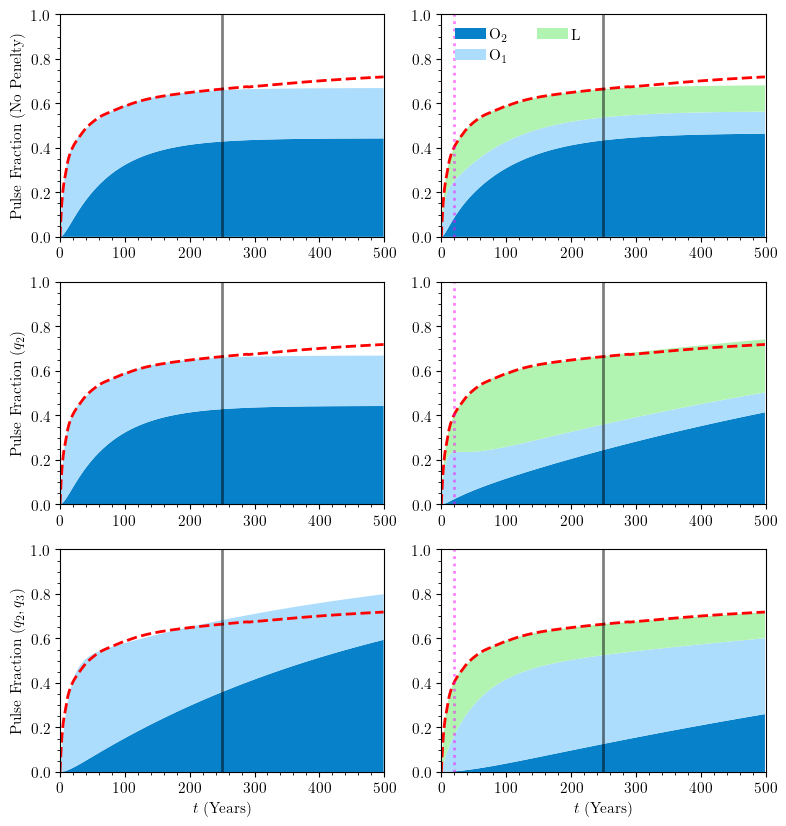

In [6]:
def plot_flux(test_name_sel_set,file_prefix='1',root=_root):

    color_A  =(0.8667,0.9059,0.9333)
    color_O1 =(0.6743529411764707, 0.8670274509803922, 0.9864313725490196)
    color_O2 =(0.03321568627450988, 0.5048784313725492, 0.7971764705882353)
    color_L  =(0.6946139705882354, 0.9532291666666667, 0.6946139705882354)

    fig, axs = make_plot(3,2)

    for test_name_sel_inx,test_name_sel in enumerate(test_name_sel_set):
        calib_data = operations.load_results(root=root,test_name=test_name_sel,T_sim_set=[125,250,500],conditions=_conditions)

        for model_inx,model_name in enumerate(calib_data.keys()): 

            info            = calib_data[model_name]['model']()
            benchmark_pulse = calib_data[model_name]['benchmark_pulse']
            A               = calib_data[model_name]['A']
            m0        = np.zeros(A.shape[0])
            m0[0]     = benchmark_pulse[0]
            m_sim     = operations.simulate_pulse(A=A, m0=m0, T=len(benchmark_pulse))

            #axs[test_name_sel_inx,model_inx].stackplot(range(0,len(benchmark_pulse)),data_set,colors=color_set )
            if '3SR' in model_name:
                axs[test_name_sel_inx,model_inx].stackplot(range(0,len(benchmark_pulse)),m_sim[2,:],m_sim[1,:],colors=[color_O2,color_O1] )
            
            if '4PR' in model_name:
                axs[test_name_sel_inx,model_inx].stackplot(range(0,len(benchmark_pulse)),m_sim[2,:],m_sim[1,:],m_sim[3,:],colors=[color_O2,color_O1,color_L] )
           
            axs[test_name_sel_inx,model_inx].plot(benchmark_pulse[0]-benchmark_pulse,linewidth=2,color='red',linestyle='--',)
                        
            if 'PR' in model_name:
                axs[test_name_sel_inx,model_inx].axvline(x=20,ymax=1,color='magenta',alpha=0.5,linestyle=':',linewidth=2)

            axs[test_name_sel_inx,model_inx].axvline(x=250,ymax=1,color='black',alpha=0.5,linewidth=2)
            axs[test_name_sel_inx,model_inx].minorticks_on()  
            axs[test_name_sel_inx,model_inx].set_ylim(top=benchmark_pulse[0])
            axs[test_name_sel_inx,model_inx].set_xlim(left=0,right=len(benchmark_pulse))

        axs[0,1].legend([r'$\textrm{O}_2$',r'$\textrm{O}_1$',r'$\textrm{L}$'],
        frameon=False,
        loc='upper left',
        handletextpad=0.2,
        #labelspacing=0.0,
        ncol=2,
        #bbox_to_anchor=(.0, .0)
        )
        axs[0,0].set_ylabel(r'Pulse Fraction (No Penelty)')
        axs[1,0].set_ylabel(r'Pulse Fraction $(q_2)$')
        axs[2,0].set_ylabel(r'Pulse Fraction $(q_2,q_3)$')

        for model_inx,model_name in enumerate(calib_data.keys()):   
            axs[-1,model_inx].set_xlabel(r'$t$ (Years)')      

    fig.savefig('fig/'+_conditions+'/analysis_flux_pen.png',dpi=300) 

plot_flux(test_name_sel_set=[_test_name_no_pen,_test_name_q2_q3,_test_name_q1_q2_q3]     ,file_prefix='1')

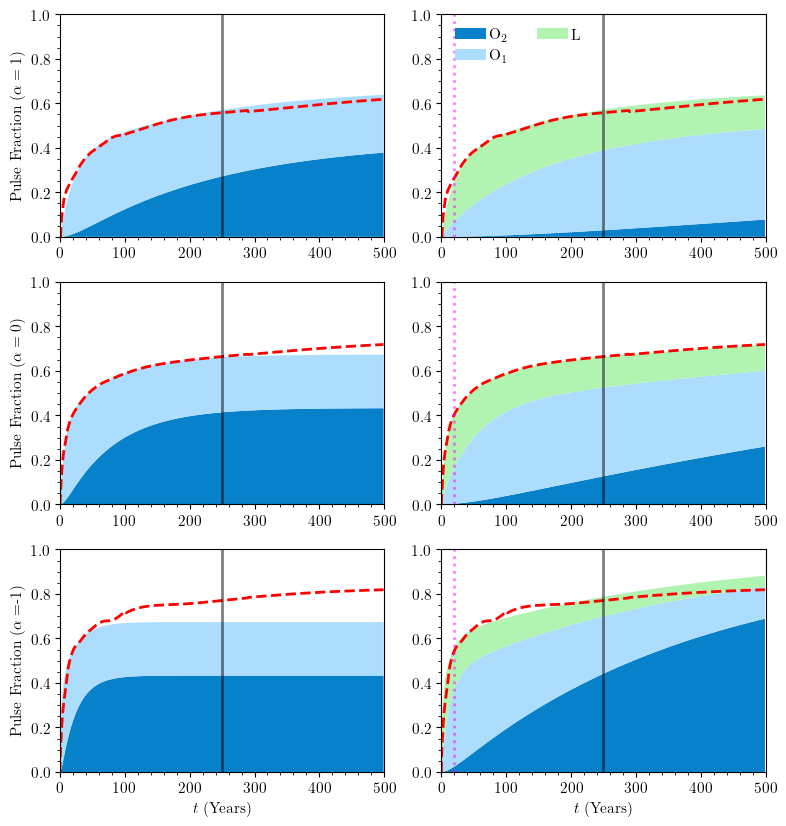

In [7]:
def plot_flux_c_set(results,c_set,root=_root):

    color_A  =(0.8667,0.9059,0.9333)
    color_O1 =(0.6743529411764707, 0.8670274509803922, 0.9864313725490196)
    color_O2 =(0.03321568627450988, 0.5048784313725492, 0.7971764705882353)
    color_L  =(0.6946139705882354, 0.9532291666666667, 0.6946139705882354)

    fig, axs = make_plot(3,2)
    for model_inx,model_name in enumerate(list(results.keys())):  
        for benchmark_inx, benchmark_name in enumerate(['MMMU','MMM','MMMD']):

            [benchmark_pulse,_] = data_load.pulse_fraction(test_type=benchmark_name, T=500,conditions=_conditions) 
            benchmark_pulse    *= 1
            info            = (results[model_name]['model'])()
            A               = results[model_name]['A']
            m0              = np.zeros(A.shape[0])
            m0[0]           = benchmark_pulse[0]
            m_sim           = operations.simulate_pulse(A=A*c_set[model_name][benchmark_inx], m0=m0, T=len(benchmark_pulse))#calib_data[model_name]['m_sim']

            data_set        = []
            color_set       = []

            if '3SR' in model_name:
                axs[benchmark_inx,model_inx].stackplot(range(0,len(benchmark_pulse)),m_sim[2,:],m_sim[1,:],colors=[color_O2,color_O1] )
            
            if '4PR' in model_name:
                axs[benchmark_inx,model_inx].stackplot(range(0,len(benchmark_pulse)),m_sim[2,:],m_sim[1,:],m_sim[3,:],colors=[color_O2,color_O1,color_L] )

            #stacks = axs[benchmark_inx,model_inx].stackplot(range(0,len(benchmark_pulse)),data_set,colors=color_set )
            axs[benchmark_inx,model_inx].plot(benchmark_pulse[0]-benchmark_pulse,linewidth=2,color='red',linestyle='--',)
                        
            if 'PR' in model_name:
                axs[benchmark_inx,model_inx].axvline(x=20,ymax=1,color='magenta',alpha=0.5,linestyle=':',linewidth=2)

            axs[benchmark_inx,model_inx].axvline(x=250,ymax=1,color='black',alpha=0.5,linewidth=2)
            axs[benchmark_inx,model_inx].minorticks_on()  
            axs[benchmark_inx,model_inx].set_ylim(top=benchmark_pulse[0])
            axs[benchmark_inx,model_inx].set_xlim(left=0,right=len(benchmark_pulse))

    axs[0,1].legend([r'$\textrm{O}_2$',r'$\textrm{O}_1$',r'$\textrm{L}$'],
    frameon=False,
    loc='upper left',
    handletextpad=0.2,
    #labelspacing=0.0,
    ncol=2)
    axs[0,0].set_ylabel(r'Pulse Fraction $(\alpha=1)$')
    axs[1,0].set_ylabel(r'Pulse Fraction $(\alpha=0)$')
    axs[2,0].set_ylabel(r'Pulse Fraction $(\alpha=$-$1)$')

    for model_inx,model_name in enumerate(list(results.keys())):   
        axs[-1,model_inx].set_xlabel(r'$t$ (Years)')       
    
    fig.savefig('fig/'+_conditions+'/analysis_flux_alpha.png',dpi=300) 

plot_flux_c_set(results=_results,c_set=c_set)